In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.models import load_model
from keras import backend as K

model = load_model('/Users/zetong/cnn.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


## helper functions

In [5]:
def load_image(image_location):
    x = np.asarray(PIL.Image.open(image_location))
    x = x.reshape(28,28)
    x = x.reshape(1, 28, 28, 1)
    x = x.astype('float32')
    x /= 255
    return x

# putting the adversarial examples and their misclassification labels in subplots
def plot_adversarials(attacks, predicted_labels):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        ax.title.set_text(str(predicted_labels[i-1]))
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    return

# a helper function to visualize a list of adversarial examples
def visualize_adversarials(attacks):
    w=10
    h=10
    fig=plt.figure(figsize=(8, 8))
    columns = len(attacks)
    rows = 1
    for i in range(1, columns*rows+1):
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(attacks[i-1].reshape((28,28)), cmap='Greys')
    plt.show()
    return

In [15]:
class cwl2:
    def __init__(self, sess, model, K=0, max_iterations=1000, step_size=0.1, initial_cost=10, SEARCH_STEPS=9):
        self.sess = sess
        self.model = model
        self.K = K
        self.max_iterations = max_iterations
        self.step_size = step_size
        self.initial_cost = initial_cost
        self.SEARCH_STEPS = SEARCH_STEPS
        
    # search for the best adversarial examples
    def find_best_attack(self, model, original_img, target_label):
        # all the valid attacks
        attacks = []
        # initial c value
        c = self.initial_cost
        K = self.K
        for s in range(self.SEARCH_STEPS):
            print(s)
            x_new = tf.Variable(np.zeros([1,28,28,1]), dtype=tf.float32)
            logits = model(x_new)
            target = target_label
            x = original_img
            nontarget_logits = newlogits = tf.concat([logits[0][0:target], logits[0][target:-1]], 0)
            loss = tf.norm(x_new-x)**2 + c*tf.math.maximum(tf.math.reduce_max(nontarget_logits) - logits[0][target], -K)
            train = tf.train.AdamOptimizer(self.step_size).minimize(loss, var_list=[x_new])
            self.sess.run(tf.global_variables_initializer())
            for i in range(self.max_iterations):
                self.sess.run(train)
                new_img = self.sess.run(x_new)
            # if the attack is sucessful
            if np.argmax(model.predict(new_img)) == target_label:
                # add it to the valid attacks collection
                attacks.append(new_img)
                # decrease c value to try to find an attack with less perturbation
                c = c*0.5
            # if the attack failed
            else:
                # increase c value to enforce the solver to find a sucessful attack
                c = c*10
        noise_norms = []
        for i in range(len(attacks)):
            noise_norms.append(np.linalg.norm(attacks[i] - x))
        best_attack = attacks[np.argmin(noise_norms)]
        return best_attack, attacks

0


Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x124abb048>>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


1
2
3
4
5
6
7
8
[[0.10028885 0.0984558  0.11078288 0.09449692 0.11206312 0.10270528
  0.0930078  0.10008038 0.09077191 0.09734702]]
[[0.10048328 0.09844277 0.10949029 0.09447131 0.11264033 0.10320875
  0.09287715 0.09994765 0.09104125 0.0973972 ]]
[[0.10162763 0.09849881 0.10845536 0.09353958 0.11126991 0.10247003
  0.09357759 0.09839903 0.09402319 0.09813896]]
[[0.10248789 0.09936863 0.11056907 0.09548719 0.11379144 0.10296033
  0.09122375 0.09700632 0.0909624  0.09614306]]
[[0.09679113 0.0962763  0.13136521 0.09717546 0.09710156 0.09614104
  0.09464365 0.10005913 0.09306742 0.09737913]]


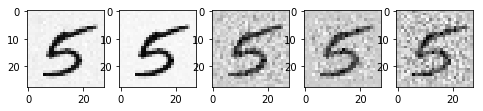

In [16]:
with tf.Session() as sess:
    x = load_image('/Users/zetong/mnist_png/testing/5/52.png')
    l2attack = cwl2(sess, model)
    best_attack, attacks = l2attack.find_best_attack(model, x, 2)
    for i in range(len(attacks)):
        print(model.predict(attacks[i]))
    visualize_adversarials(attacks)